In [1]:
import os 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cargar_carpetas(carpeta, carpeta_estruc, carpeta_dosis ):
    direc = Path(carpeta +"/")
    estruc = [direc/carpeta_estruc/i for i in os.listdir(direc/carpeta_estruc)]
    dosis = [direc/carpeta_dosis/i for i in os.listdir(direc/carpeta_dosis)]
    estruc = sorted(estruc)
    dosis = sorted(dosis)
    print("Carpetas cargadas")
    if len(estruc) != len(dosis):
        print("La cantidad de volúmenes no es equivalente a la cantidad de máscaras")
    print('La carpeta {} tiene {} volúmenes y la carpeta {} tiene {} máscaras'.format(carpeta_estruc, len(estruc),carpeta_dosis, len(dosis)))
    
    return estruc, dosis

In [3]:
import torch.utils.data

In [4]:
class Dataset (torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
       
    def __len__(self):
        assert len(self.x) == len(self.y), "La cantidad de volúmenes no es equivalente a la cantidad de máscaras"
        return len(self.x)
    
    
    def __getitem__(self,ix):
        img = np.load(self.x[ix])
        mask = np.load(self.y[ix])
        img_oh = (np.arange(4) == img[...,None]).astype(np.float64)
        img_tensor= torch.tensor(img_oh).permute(3, 0, 1, 2)
        mask_e = mask/36.25
        mask_tensor = torch.tensor(mask_e).unsqueeze(0)
        
        return img_tensor, mask_tensor

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv3d(ci, co, 3, padding=1),
        torch.nn.BatchNorm3d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
    return torch.nn.Sequential(
        torch.nn.MaxPool3d((2, 2, 2)),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose3d(ci, co, 2, stride=2, padding=0)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
#         diffX = x2.size()[2] - x1.size()[2] # si no se usa zero padding en las convoluciónes se deben cortar antes de cat
#         diffY = x2.size()[3] - x1.size()[3]
#         x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], axis=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=4):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [64, 128, 256, 512]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv3d(c[0],  1, kernel_size=1, padding=0)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [7]:
import math
from sklearn.metrics import f1_score, jaccard_score

In [8]:
def dice(true, pred, smooth=0.0000001):
    true=torch.round(true, decimals=1) # se redondea con un decimal los valores de los pixeles para que las coincidencias no sea tan excasas 
    pred=torch.round(pred, decimals=1) # como lo son cuando se tienen 6 valores despues de la coma.
    intersect = torch.sum((true == pred).int()) # la intersección son los pixeles en donde coincide el valor en los dos ejemplos 
    total = math.prod(true.shape) + math.prod(pred.shape) # el total es la suma de todos los pixeles que forman ambos ejemplos
    return   torch.mean((2 * intersect) /(total +smooth)) 

In [9]:
def iou(true, pred, smooth=0.0000001):
    true=torch.round(true, decimals=1)
    pred=torch.round(pred, decimals=1)
    intersect = torch.sum((true == pred).int())
    union = math.prod(true.shape) + math.prod(pred.shape)-intersect
    return   torch.mean(intersect /(union+smooth))

In [10]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, true, pred):
        true = true.view(-1)
        pred = pred.view(-1)
        # BCE loss
        bce_loss = nn.BCEWithLogitsLoss()(true, pred).double()
        # Dice Loss
        dice_coef = ((-(true-pred)**2+1).double().sum()) / (math.prod(true.shape))
        return bce_loss + (1 - dice_coef)

In [11]:
class SharpLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        
    def forward(self, true, pred):
        true = true.view(-1)
        pred = pred.view(-1)
        
        n=math.prod(true.shape) #cantidad total de pixeles, anchoxaltoxprofundidad
        
        factor=1/(1+torch.exp(-(true-0.03)*100)) #función sigmoide modificada
        
        dif=(true-pred)**2 #diferencia al cuadrado para el MSE
        
        suma= (factor*dif).double().sum() #sumatoria de MSE*sigmoide
        
        final=suma/n #división por el numero total de pixeles 
        
        return final

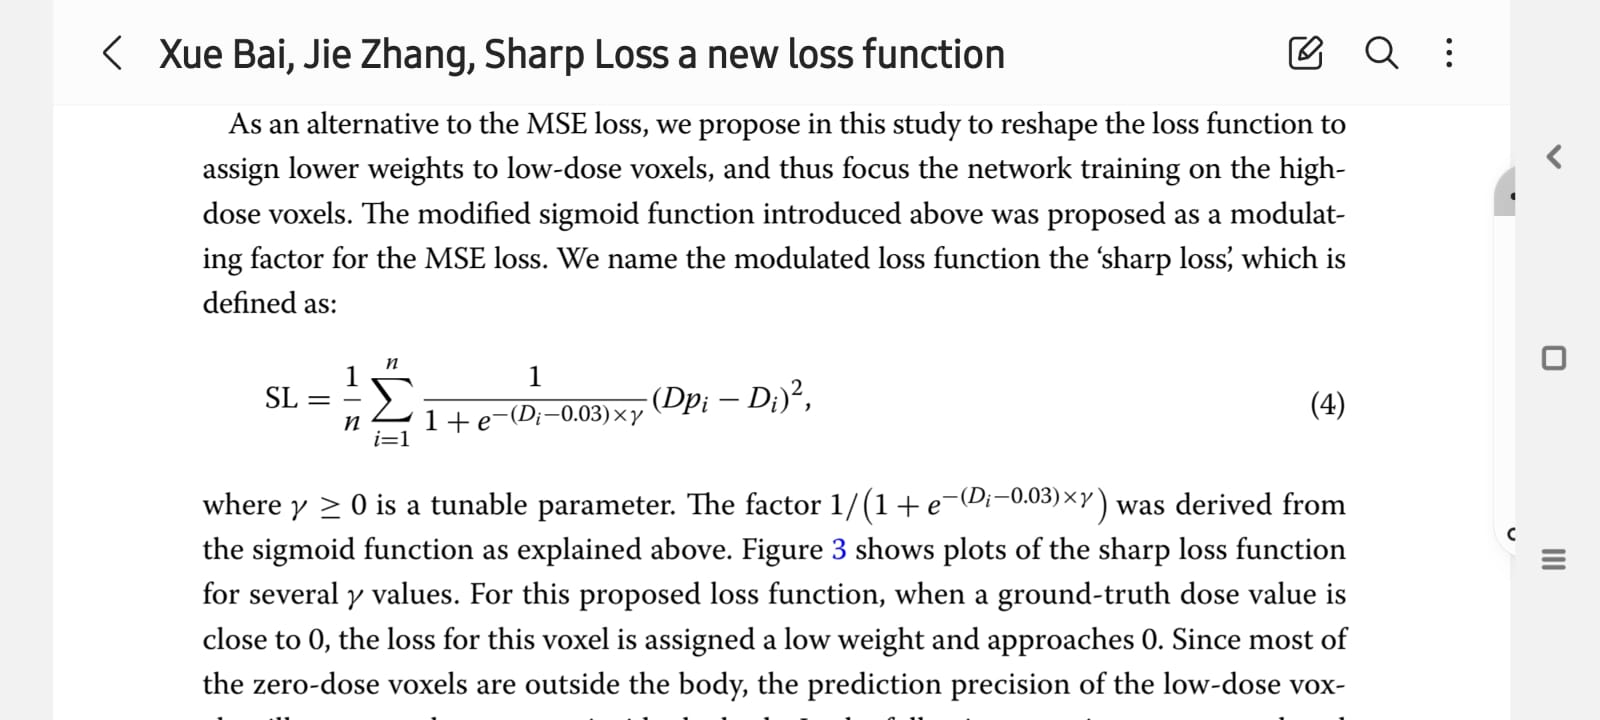

In [12]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    
    return elapsed_mins, elapsed_secs

In [13]:
from tqdm import tqdm
import pandas as pd
import random
import time

In [14]:
estruc, dosis = cargar_carpetas('DatasetPI/EntrenamientoPI', 'Estructuras', 'Dosis')

Carpetas cargadas
La carpeta Estructuras tiene 240 volúmenes y la carpeta Dosis tiene 240 máscaras


In [15]:
dataset = {
    "train" : Dataset(estruc[:180], dosis[:180]),
    "test" : Dataset(estruc[180:], dosis[180:])}

len(dataset["train"]), len(dataset["test"])

(180, 60)

In [16]:
dataloader = {
    "train" : torch.utils.data.DataLoader(dataset["train"], batch_size=2, shuffle=True, pin_memory=True),
    "test" : torch.utils.data.DataLoader(dataset["test"], batch_size=2, pin_memory=True) }

imges, maskes = next(iter(dataloader["train"]))
imges.shape, maskes.shape

(torch.Size([2, 4, 64, 64, 64]), torch.Size([2, 1, 64, 64, 64]))

In [22]:
def fit(model, dataloader, epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SharpLoss()
    model.to(device)
    hist = {'loss': [], 'test_loss': []}
    met = {'iou': [], 'dice': [], 'iou_test': [], 'dice_test': []}
    start_time = time.time()
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")
        bar = tqdm(dataloader['train'])
        train_loss= []
        model.train()
        for imges, maskes in bar:
            imges, maskes = imges.to(device, dtype=torch.float), maskes.to(device, dtype=torch.float)
            optimizer.zero_grad()
            y_hat = model(imges)
            loss = criterion(y_hat, maskes)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, maskes)
            dices = dice(y_hat, maskes)
            train_loss.append(loss.item())
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {ious:.3f} dice {dices:.3f}")
        hist['loss'].append(np.mean(train_loss))
        met['dice'].append(dices.cpu().numpy()*1)
        met['iou'].append(ious.cpu().numpy()*1)
        bar = tqdm(dataloader['test'])
        test_loss = []
        model.eval()
        with torch.no_grad():
            for imges, maskes in bar:
                imges, maskes = imges.to(device,dtype=torch.float), maskes.to(device, dtype=torch.float)
                y_hat = model(imges)
                loss = criterion(y_hat, maskes)
                test_loss.append(loss.item())
                ious = iou(y_hat, maskes)
                dices = dice(y_hat, maskes)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} iou {ious:.3f} dice {dices:.3f}")
        hist['test_loss'].append(np.mean(test_loss))
        met['dice_test'].append(dices.cpu().numpy()*1)
        met['iou_test'].append(ious.cpu().numpy()*1)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    data_str = f' Entrenamiento de {epochs} epocas finalizado en {epoch_mins}m {epoch_secs}s\n'
    print()
    print(data_str)
    
    return hist, met

# Entrenamiento con BCE Dice Loss

In [18]:
device = torch.device('cuda')
model = UNet()
hist, met = fit(model, dataloader, epochs=10)


Epoch 1/10


test_loss 0.69621 iou 0.063 dice 0.119: 100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.79it/s]



Epoch 2/10


test_loss 0.66644 iou 0.085 dice 0.157: 100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.89it/s]



Epoch 3/10


test_loss 0.68752 iou 0.088 dice 0.162: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.03it/s]



Epoch 4/10


test_loss 0.65875 iou 0.117 dice 0.209: 100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  3.00it/s]



Epoch 5/10


test_loss 0.65578 iou 0.098 dice 0.179: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.03it/s]



Epoch 6/10


test_loss 0.65439 iou 0.093 dice 0.170: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.11it/s]



Epoch 7/10


test_loss 0.65430 iou 0.065 dice 0.121: 100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.90it/s]



Epoch 8/10


test_loss 0.65347 iou 0.084 dice 0.155: 100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.72it/s]



Epoch 9/10


test_loss 0.65249 iou 0.085 dice 0.157: 100%|███████████████████████████████████████████| 30/30 [00:12<00:00,  2.49it/s]



Epoch 10/10


test_loss 0.65293 iou 0.084 dice 0.155: 100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.56it/s]


 Entrenamiento de 10 epocas finalizado en 11m 47s



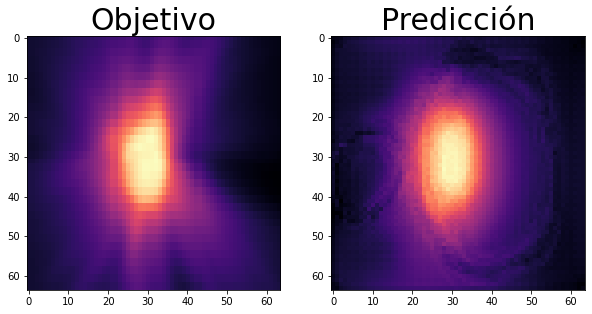

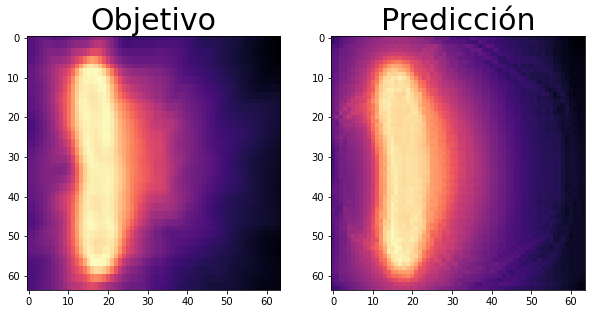

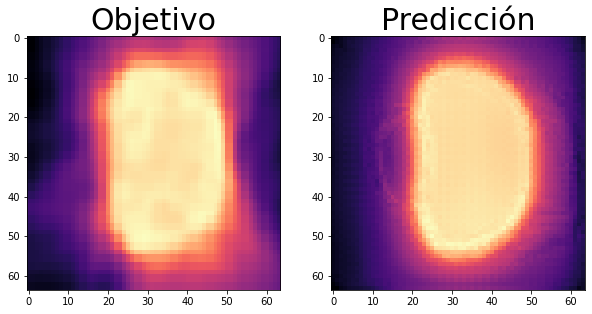

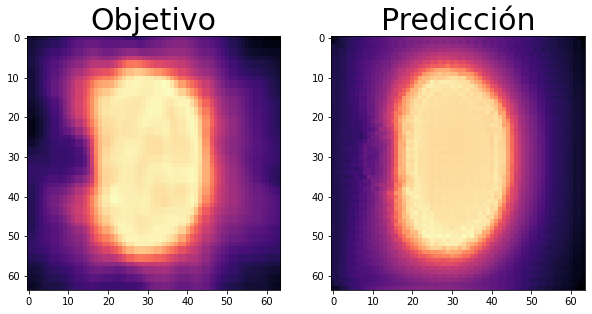

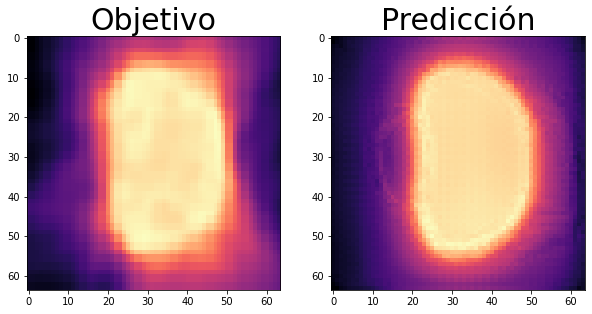

In [19]:
#10 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()

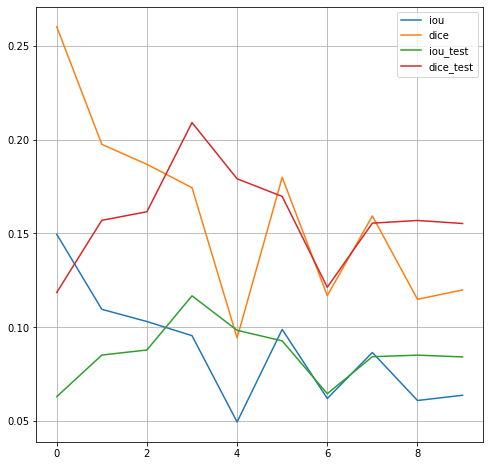

In [20]:
#10 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

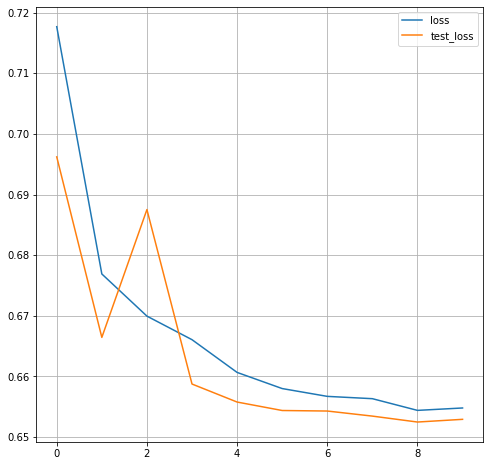

In [21]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

# Entrenamiento con Sharp Loss

In [24]:
device = torch.device('cuda')
model = UNet()
hist, met = fit(model, dataloader, epochs=5)


Epoch 1/5


test_loss nan iou 0.000 dice 0.000: 100%|███████████████████████████████████████████████| 30/30 [00:09<00:00,  3.10it/s]



Epoch 2/5


test_loss nan iou 0.000 dice 0.000: 100%|███████████████████████████████████████████████| 30/30 [00:09<00:00,  3.23it/s]



Epoch 3/5


test_loss nan iou 0.000 dice 0.000: 100%|███████████████████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 4/5


test_loss nan iou 0.000 dice 0.000: 100%|███████████████████████████████████████████████| 30/30 [00:11<00:00,  2.54it/s]



Epoch 5/5


test_loss nan iou 0.000 dice 0.000: 100%|███████████████████████████████████████████████| 30/30 [00:13<00:00,  2.26it/s]


 Entrenamiento de 5 epocas finalizado en 5m 26s



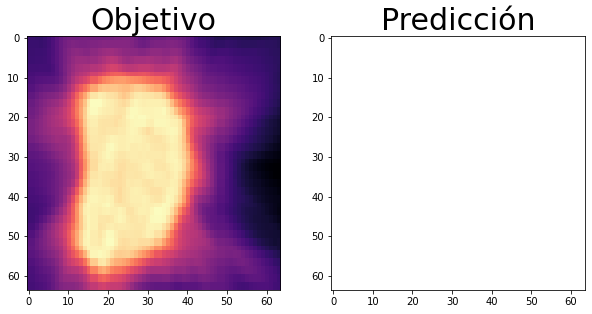

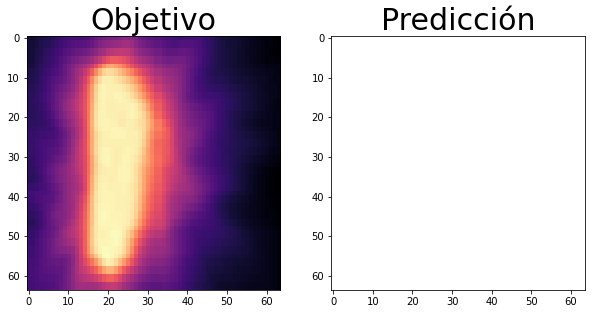

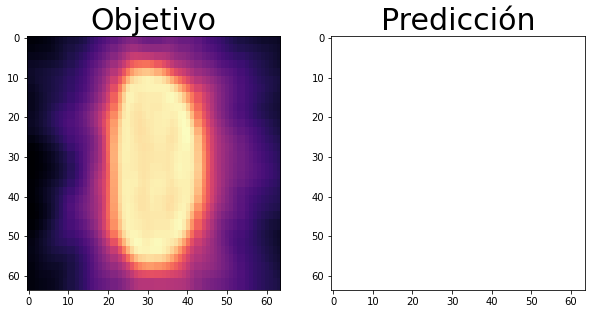

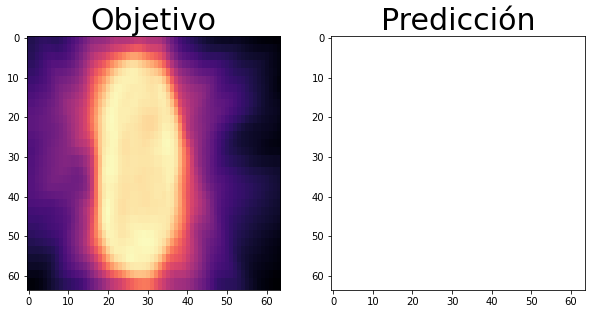

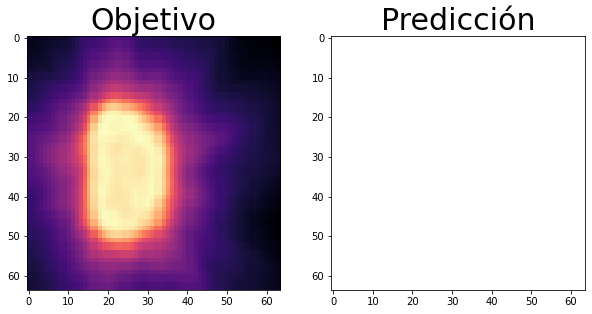

In [25]:
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()